# Shallow ConvNet
Architecture implemented after the description by Schirrmeister et al. (2017) in Convolutional Neural Networks in EEG Analysis (https://onlinelibrary.wiley.com/doi/10.1002/hbm.23730). Designed to mimic the FBCSP pipeline.

In [1]:
import glob
import mne
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
# Standard channel sets
CHANNELS_64 = None  # use all
CHANNELS_38 = list(range(38))
CHANNELS_19 = ["Fp1","Fp2","F3","F4","C3","C4","P3","P4","O1","O2",
                "F7","F8","T3","T4","T5","T6","Fz","Cz","Pz"]
CHANNELS_8 = ["F3","F4","C3","C4","Cz","P3","P4","Pz"]

def pick_channels(raw, n_channels=64):
    if n_channels == 64 or n_channels is None:
        return raw
    elif n_channels == 38:
        return raw.copy().pick_channels([raw.ch_names[i] for i in CHANNELS_38])
    elif n_channels == 19:
        return raw.copy().pick_channels(CHANNELS_19)
    elif n_channels == 8:
        return raw.copy().pick_channels(CHANNELS_8)

In [3]:
def process_file(file_path, T=4, n_channels=64, ds=1):
    """
    Processes one EDF file: filtering, referencing, epoching, removing T0, normalization
    """
    raw = mne.io.read_raw_edf(file_path, preload=True)
    
    # Bandpass filter 4-40 Hz
    raw.filter(4., 40., fir_design='firwin')
    
    # Common average reference
    raw.set_eeg_reference("average")
    
    # Channel selection
    raw = pick_channels(raw, n_channels)
    
    # Convert annotations to events
    event_id = {'T0':0, 'T1':1, 'T2':2}
    events, _ = mne.events_from_annotations(raw, event_id=event_id)
    
    # Epoching
    epochs = mne.Epochs(
        raw, events, event_id=event_id,
        tmin=0, tmax=T,
        baseline=None,
        preload=True
    )
    
    X = epochs.get_data()  # shape: trials × channels × samples
    y = epochs.events[:, -1]  # labels
    
    # Remove T0 (idle) for left vs right classification
    mask = y != 0
    X = X[mask]
    y = y[mask]
    y = y - 1  # relabel: T1 -> 0, T2 -> 1
    
    # Downsampling
    if ds > 1:
        X = X[:, :, ::ds]
    
    # Normalize per trial
    for i in range(len(X)):
        X[i] = (X[i] - X[i].mean(axis=-1, keepdims=True)) / (X[i].std(axis=-1, keepdims=True)+1e-6)
    
    return X, y


In [4]:
all_files = glob.glob("../data/full_data/S*/S*R*.edf")
# all_files = all_files[:30]  # limit to first 30 files for quicker testing
print(f"Found {len(all_files)} EDF files")

X_list, y_list = [], []

for f in all_files:
    X, y = process_file(f, T=4, n_channels=64, ds=1)
    X_list.append(X)
    y_list.append(y)

X_all = np.concatenate(X_list)
y_all = np.concatenate(y_list)

print("Final shape:", X_all.shape, y_all.shape)

Found 120 EDF files
Extracting EDF parameters from E:\dev\Projects\EEG_MotorImagery_Project\data\full_data\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 265 samples (1.656 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), 

In [5]:
X_tensor = torch.tensor(X_all, dtype=torch.float32).unsqueeze(1)  # (trials, 1, C, T)
y_tensor = torch.tensor(y_all, dtype=torch.long)

print(X_tensor.shape)  # should be (N, 1, 64, 640)

torch.Size([1796, 1, 64, 641])


In [6]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split train/test (e.g., 80/20)
num_samples = X_tensor.shape[0]
train_size = int(0.8*num_samples)
val_size = int(0.1*num_samples)
test_size = num_samples - train_size - val_size

train_X, val_X, test_X = torch.utils.data.random_split(X_tensor, [train_size, val_size, test_size])
train_y, val_y, test_y = torch.utils.data.random_split(y_tensor, [train_size, val_size, test_size])

train_dataset = EEGDataset(train_X, train_y)
val_dataset = EEGDataset(val_X, val_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [15]:
class Square(nn.Module):
    """x -> x^2"""
    def forward(self, x):
        return x ** 2

class SafeLog(nn.Module):
    """x -> log(x) with numerical stabilisation"""
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        return torch.log(torch.clamp(x, min=self.eps))

# Shallow ConvNet Model
class ShallowConvNet(nn.Module):
    def __init__(self, n_classes: int, n_channels: int = 64, input_time: int = 640, dropout=0.5):
        """
        Parameters
        ----------
        n_classes : int
            Number of output classes.
        n_channels : int
            Number of electrodes (paper 44 #TODO: I think this should be 64).
        input_time : int
            Signal input time (paper 180 #TODO: I think this should sample_rate with 160).
        """
        super(ShallowConvNet, self).__init__()
        
        # Hyperparameters
        self.n_filters = 40
        self.n_channels = n_channels
        
        # Layers
        # Input time x electrodes (paper 534x44, we _x64)
        self.temporal_conv = nn.Conv2d(
            in_channels=1,
            out_channels=self.n_filters,
            kernel_size=(1, 16), # paper used 25 for sample rate 250 -> we use 16 for sample rate 160?
            bias=False
        ) # 40 Units temporal conv
        
        self.bn = nn.BatchNorm2d(self.n_filters)
        
        self.spatial_filter = nn.Conv2d(
            in_channels=self.n_filters,
            out_channels=self.n_filters,
            kernel_size=(self.n_channels, 1),
            bias=False # arl disables bias
        ) # 40 Units spatial filter (conv)
        
        self.square = Square() # Squaring Non-linearity
        self.mean_pooling = nn.AvgPool2d(kernel_size=(1, 48), stride=(1, 9)) # 75x1 kernel Mean Pooling w. 15 x 1 stride -> 48, 1 and 9, 1 (or 10, 1?). Only AvgPooling available.
        self.log_activation = SafeLog() # Log activation
        
        # Arl adds dropout layer
        self.dropout = nn.Dropout(dropout)
        
        n_features = self._get_flatten_size(input_time)
        self.dense = nn.Linear(n_features, n_classes) # Linear classification
        #self.softmax = nn.Softmax(dim=1) # softmax

    def _get_flatten_size(self, input_time):
        x = torch.zeros(1,1,self.n_channels,input_time)
        x = self.temporal_conv(x)
        x = self.bn(x)
        x = self.spatial_filter(x)
        x = self.square(x)
        x = self.mean_pooling(x)
        x = self.log_activation(x)
        x = self.dropout(x)
        return x.view(1,-1).shape[1]

    def forward(self, x):
        out = self.temporal_conv(x)
        out = self.bn(out)
        out = self.spatial_filter(out)
        out = self.square(out)
        out = self.mean_pooling(out)
        out = self.log_activation(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1)
        out = self.dense(out)
        #out = self.softmax(out)
        return out

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ShallowConvNet(n_channels=64, n_classes=2, input_time=X_tensor.shape[-1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100

# ======== Initialize lists to store metrics ========
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # ======== Training ========
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        _, preds = outputs.max(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # ======== Validation ========
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item() * X_batch.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

Epoch 1/100: Train Loss=0.9323, Train Acc=0.5202, Val Loss=0.7646, Val Acc=0.5307
Epoch 2/100: Train Loss=0.7551, Train Acc=0.5355, Val Loss=0.6886, Val Acc=0.5140
Epoch 3/100: Train Loss=0.6628, Train Acc=0.6100, Val Loss=0.6854, Val Acc=0.5531
Epoch 4/100: Train Loss=0.6280, Train Acc=0.6623, Val Loss=0.7321, Val Acc=0.5028
Epoch 5/100: Train Loss=0.5882, Train Acc=0.6852, Val Loss=0.7482, Val Acc=0.4972
Epoch 6/100: Train Loss=0.5323, Train Acc=0.7409, Val Loss=0.7109, Val Acc=0.5307
Epoch 7/100: Train Loss=0.4720, Train Acc=0.8050, Val Loss=0.7435, Val Acc=0.5363
Epoch 8/100: Train Loss=0.4110, Train Acc=0.8433, Val Loss=0.7111, Val Acc=0.5587
Epoch 9/100: Train Loss=0.3701, Train Acc=0.8684, Val Loss=0.7763, Val Acc=0.5028
Epoch 10/100: Train Loss=0.3216, Train Acc=0.8948, Val Loss=0.7358, Val Acc=0.6089
Epoch 11/100: Train Loss=0.2830, Train Acc=0.9143, Val Loss=0.8031, Val Acc=0.5363
Epoch 12/100: Train Loss=0.2333, Train Acc=0.9304, Val Loss=0.7880, Val Acc=0.5028
Epoch 13/100:

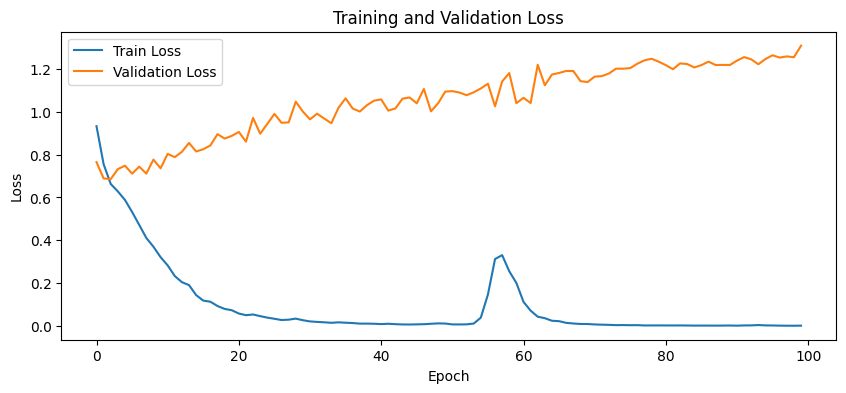

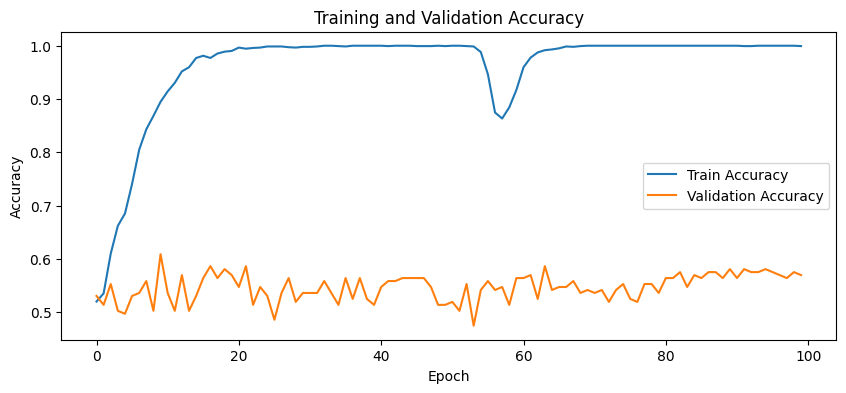

In [17]:
import matplotlib.pyplot as plt

# ======== Loss Curve ========
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# ======== Accuracy Curve ========
plt.figure(figsize=(10,4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()